# MICrONS Precomputed Skeleton Download

This tutorial walks through the key functions needed to access the MICrONS dataset programmatically and highlights key resources within it. While this tutorial is written for the MICrONS dataset specifically, the underlying technology (CAVE) is being used for multiple connectomics dataset. So, the interface presented here can be used to query them as well.

__This notebook is made to run in Google Colab. Each time your start the remote kernel, you will need to reinstall CAVE and add your token__

## CAVEclient and setup

The __CAVEclient__ is a python library that facilitates communication with a CAVE system. For convenience, we also use the package __skeleton_plot__ which handles rendering the precomputed skeletons. Both packages can be installed with pip.

In [ ]:
!pip install -q caveclient 
!pip install -q skeleton_plot 

and imported like so:

In [ ]:
import caveclient

## CAVE account setup

In order to manage server traffic, every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. The CAVE infrastructure can be read about in more detail on our preprint. The MICrONS data is publicly available which means that no extra permissions need to be given to a new user account to access the data. Bulk downloads of some static data are also available without an account on MICrONs Explorer.

__A Google account (or Google-enabled account) is required to create a CAVE account.__

Go to: https://global.daf-apis.com/auth/api/v1/user/token to view a list of your existing tokens

If you have never made a token before:
1. go here: https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public to accept terms of service
2. then go here https://global.daf-apis.com/auth/api/v1/create_token to create a new token.

### Set or save your token

From the website that just opened up, paste your token here:

In [ ]:
my_token = "PASTE_TOKEN_HERE"

## Libraries for this notebook

In [ ]:
from meshparty import skeleton
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import skeleton_plot

In [ ]:
# Inititalize the CAVEclient
datastack_name = "minnie65_public"

client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

# specify the materialization version, for consistency across time",
client.version = 943

__Versioning note:__ We use version 943 is this notebook because it corresponds with the most recent static segmentation, which is what you see on [microns-explorer.org](https://www.microns-explorer.org/gallery-mm3)

The most recent public version at the time of writing (2/1/2025) is __version 1300__.

__Versioning note:__ We use version 943 is this notebook because it corresponds with the most recent static segmentation, which is what you see on [microns-explorer.org](https://www.microns-explorer.org/gallery-mm3)

The most recent public version at the time of writing (2/1/2025) is __version 1300__.

## What is a Skeleton?

Often in thinking about neurons, you want to measure things along a linear dimension of a neuron.

However, the segmentation is a full complex 3d shape that makes this non-trivial.
There are methods for reducing the shape of a segmented neuron down to a linear tree like structure usually referred to as a skeleton. We have precalculated skeletons for a large number of cells in the dataset, including all the proofread cells, and many of the excitatory cells with a single soma in the dataset, and these are available on the harddrives and in the aws directory.

These skeletons are stored in the cloud as a bytes-IO object, which can be viewed in __Neuroglancer__, or downloaded with __CAVE.skeleton__ module. These precomputed skeletons also contain annotations on the skeletons that have the synapses, which skeleton nodes are axon and which are dendrite, and which are likely the apical dendrite of excitatory neurons.


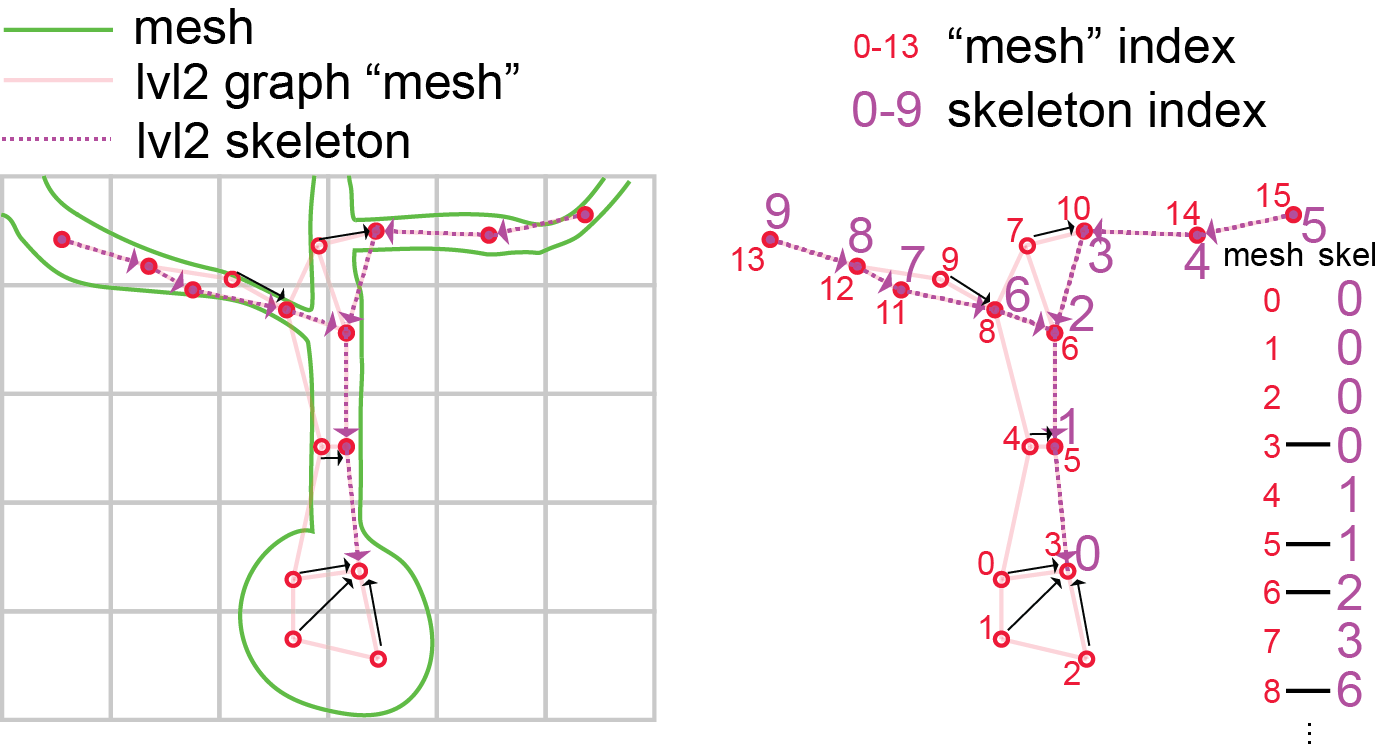

For more on how skeletons are generated from the mesh objects, and additional tools for generating, cacheing, and downloading meshes, [see the Skeleton Service documentation](https://caveconnectome.github.io/CAVEclient/tutorials/skeletonization/)

## Download skeleton as dictionary
Retrieve a skeleton using `get_skeleton()`. The available output_formats (described below) are:

* `dict` containing vertices, edges, radius, compartment, and various metadata (default if unspecified)
* `swc` a Pandas Dataframe in the SWC format, with ordered vertices, edges, compartment labels, and radius.
* 
Note: if the skeleton doesn't exist in the server cache, it may take 20-60 seconds to generate the skeleton before it is returned. This function will block during that time. Any subsequent retrieval of the same skeleton should go very quickly however.

In [ ]:
root_id = 864691134918592778
sk_dict = client.skeleton.get_skeleton(root_id, output_format='dict')

sk_dict.keys()

## Convert dictionary to meshwork skeleton
We use the python package __Meshparty__ to convert between mesh representations of neurons, and skeleton representations. 

Skeletons are "tree-like", where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices. Because of this, for a skeleton there are well-defined directions "away from root" and "towards root" and few types of vertices have special names:

Converting the pregenerated skeleton `sk_dict` to a meshwork object `sk` converts the skeleton to a graph object, for convenient representation and analysis.

In [ ]:
sk = skeleton.Skeleton.from_dict(sk_dict)

## Plot with skeleton_plot

Our convenience package __skeleton_plot__ renders the skeleton in aligned, 2D views, with the compartments labeled in different colors. Here, _dendrite_ is red, _axon_ is blue, and _soma_ (the root of the connected graph) is olive

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

skeleton_plot.plot_tools.plot_skel(sk=sk,
                                   invert_y=True,
                                   pull_compartment_colors=True,
                                   plot_soma=True,
                                   ax=ax)

## Skeleton Properties and Methods
To analyze this skeleton in a more sophisticated way, it is helpful to think of it as a graph, and the meshwork object has a bunch of tools and properties to help you utilize the skeleton graph.

Let's list some of the most useful ones below You access each of these with `sk.*` Use the ? to read more details about each one

__Properties__

* `branch_points`: a list of skeleton vertices which are branches
* `root`: the skeleton vertice which is the soma
* `distance_to_root`: an array the length of vertices which tells you how far away from the root each vertex is
* `root_position`: the position of the root node in nanometers
* `end_points`: the tips of the neuron
* `cover_paths`: a list of arrays containing vertex indices that describe individual paths that in total cover the neuron without repeating a vertex. Each path starts at an end point and continues toward root, stopping once it gets to a vertex already listed in a previously defined path. Paths are ordered to start with the end points farthest from root first. Each skeleton vertex appears in exactly one cover path.
* `csgraph`: a scipy.sparse.csr.csr_matrix containing a graph representation of the skeleton. Useful to do more advanced graph operations and algorithms. https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html
* `kdtree`: a scipy.spatial.ckdtree.cKDTree containing the vertices of skeleton as a kdtree. Useful for quickly finding points that are nearby. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

__Methods__

* `path_length(paths=None)`: the path length of the whole neuron if no arguments, or pass a list of paths to get the path length of that. A path is just a list of vertices which are connected by edges.
* `path_to_root(vertex_index)`: returns the path to the root from the passed vertex
* `path_between(source_index, target_index)`: the shortest path between the source vertex index and the target vertex index
* `child_nodes(vertex_indices)`: a list of arrays listing the children of the vertex indices passed in
* `parent_nodes(vertex_indices)`: an array listing the parent of the vertex indices passed in

### Estimate path length

In [ ]:
# Select the indices associated with the dendrites
sk_compartments = np.array(sk.vertex_properties['compartment'])

dendrite_inds = (sk_compartments==3) | (sk_compartments==4)| (sk_compartments==1) #soma is included here to connect the dendrite graphs 

# create new skeleton that masks (selects) only the dendrite
sk_dendrite = sk.apply_mask(dendrite_inds)
print("Dendrite pathlength of all branches is : ", sk_dendrite.path_length() / 1000, ' um')

In [ ]:
# Select the indices associated with the dendrites
sk_compartments = np.array(sk.vertex_properties['compartment'])

axon_inds = (sk_compartments==2) 

# create new skeleton that masks (selects) only the axon
sk_axon = sk.apply_mask(axon_inds)
print("Axon pathlength is : ", sk_axon.path_length() / 1000, ' um')

## Estimate synaptic density

In [ ]:
# Calculate synapse density (CAVE query)
syn_in = client.materialize.synapse_query(post_ids=root_id, 
                                          split_positions=True, 
                                          desired_resolution=[1,1,1])
syn_out = client.materialize.synapse_query(pre_ids=root_id, 
                                           split_positions=True, 
                                           desired_resolution=[1,1,1])

print("Dendrite synaptic density is : ", len(syn_in) / (sk_dendrite.path_length()/1000), ' per um')
print("Axon synaptic density is : ", len(syn_out) / (sk_axon.path_length()/1000), ' per um')

## Plot synapses on skeleton

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

skeleton_plot.plot_tools.plot_skel(sk=sk,
                                   invert_y=True,
                                   pull_compartment_colors=False,
                                   plot_soma=True, 
                                   ax=ax)

sns.scatterplot(data=syn_in, x="ctr_pt_position_x", y="ctr_pt_position_y", 
                s=1, color="c", alpha=0.75, edgecolor=None, zorder=100, ax=ax) 

sns.scatterplot(data=syn_out, x="ctr_pt_position_x", y="ctr_pt_position_y", 
                s=1, color="magenta", alpha=1, edgecolor=None, zorder=100, ax=ax) 